In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
from torch.utils.data import TensorDataset, Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

mat_file_path = '/content/drive/MyDrive/combustion_img_13.mat'

In [ ]:
f = h5py.File(mat_file_path, 'r')

In [ ]:
with h5py.File(mat_file_path, 'r') as f:
    train_x = f.get("train_set_x")
    train_y = f.get("train_set_y")
    print("Train set shape:", train_x.shape)
    print("Train set data type:", train_x.dtype)
    print("Label set shape:", train_y.shape)
    print("Label set data type:", train_y.dtype)

Train set shape: (25000, 54000)
Train set data type: uint8
Label set shape: (54000, 1)
Label set data type: uint8


In [ ]:
with h5py.File(mat_file_path, 'r') as f:
    # Use [:] to read the data into memory as a NumPy array
    train_x = np.array(f.get("train_set_x")[:5])  # Read only the first 5 elements
    train_y = np.array(f.get("train_set_y")[:5])  # Assuming train_y is correctly aligned with train_x

print("Sample data from train set:", train_x)
print("Sample labels from train set:", train_y)

Sample data from train set: [[ 0  0  0 ... 24 23 23]
 [ 0  0  0 ... 28 27 27]
 [ 0  0  0 ... 30 30 28]
 [ 0  0  0 ... 30 29 28]
 [ 0  0  0 ... 26 25 24]]
Sample labels from train set: [[1]
 [1]
 [1]
 [1]
 [1]]


In [ ]:
with h5py.File(mat_file_path, 'r') as f:
    # Assuming 'train_set_x' is a 2D array with shape [features, samples]
    train_x = f.get("train_set_x")[:]  # Load the entire data into memory
    train_y = f.get("train_set_y")[:]  # Assuming this aligns with the samples

# Transpose the data to have samples as the first dimension
train_data = train_x.T  # Now shape should be [54000, 25000]

print("Transposed shape:", train_data.shape)

Transposed shape: (54000, 25000)


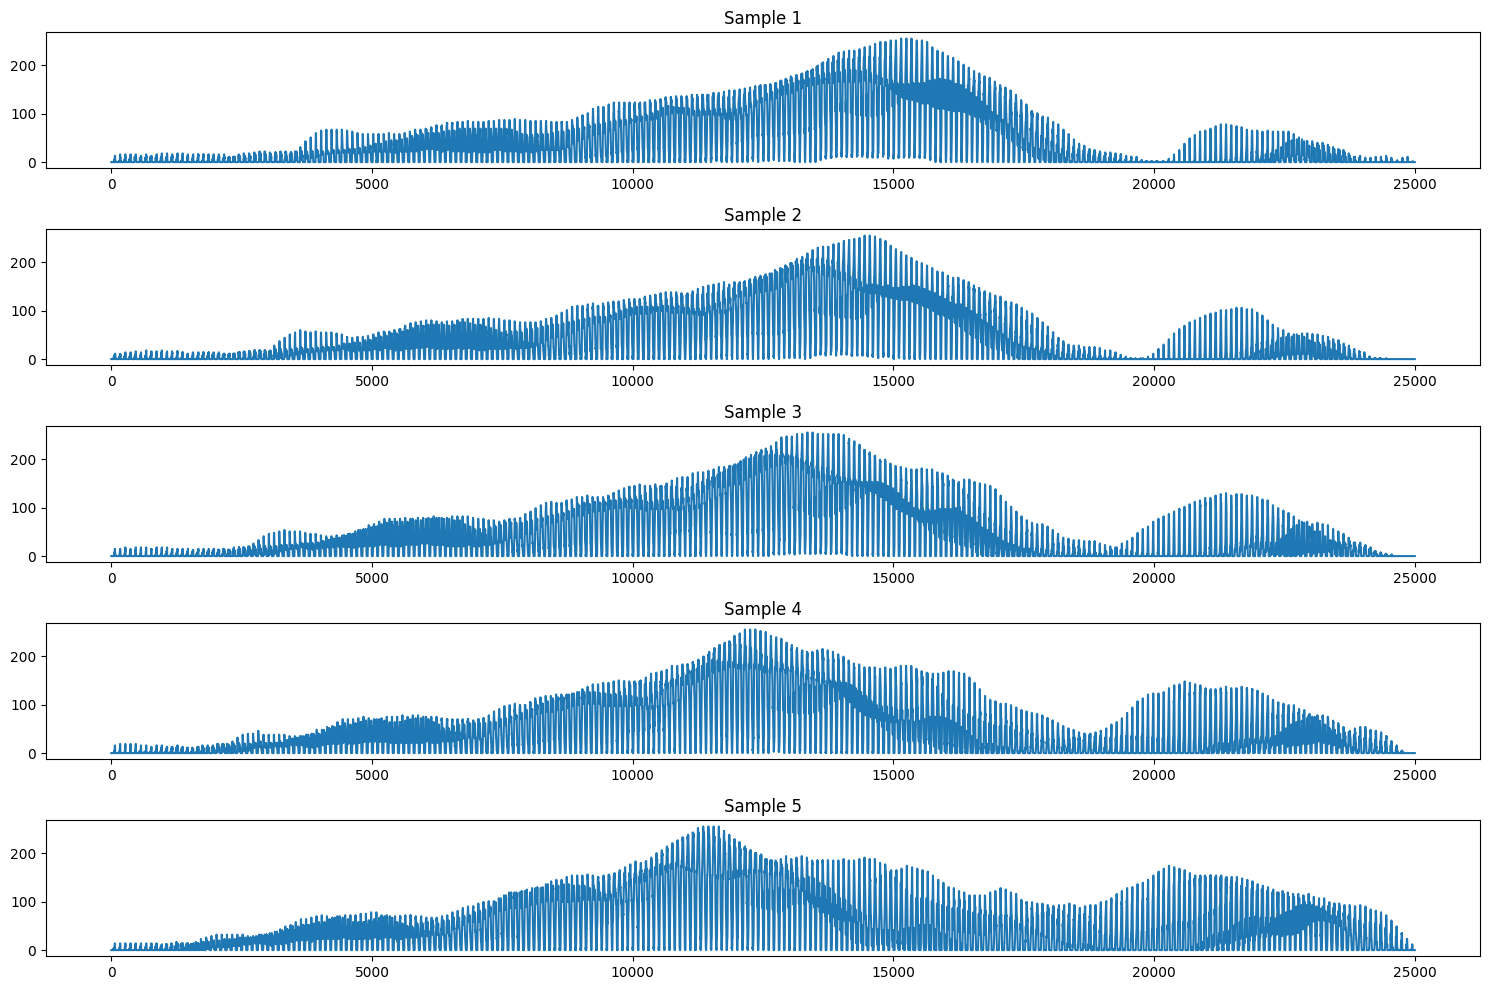

In [ ]:
num_samples_to_plot = 5

plt.figure(figsize=(15, 10))
for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    plt.plot(train_data[i])
    plt.title(f"Sample {i+1}")
    plt.tight_layout()

plt.show()

In [ ]:
# Open the .mat file
# do not use
with h5py.File(mat_file_path, 'r') as file:
    train_images = torch.tensor(file['train_set_x'][:], dtype=torch.float)
    train_labels = torch.tensor(file['train_set_y'][:], dtype=torch.long)
    valid_images = torch.tensor(file['valid_set_x'][:], dtype=torch.float)
    valid_labels = torch.tensor(file['valid_set_y'][:], dtype=torch.long)
    test_images = torch.tensor(file['test_set_x'][:], dtype=torch.float)
    test_labels = torch.tensor(file['test_set_y'][:], dtype=torch.long)

    # Reshape the images to [num_samples, channels, height, width]
    train_images = train_images.reshape(-1, 250, 100)
    valid_images = valid_images.reshape(-1, 1, 250, 100)
    test_images = test_images.reshape(-1, 1, 250, 100)
    train_images = train_images.transpose(0, 2, 1)
    valid_images = valid_images.transpose(2, 3)
    test_images = test_images.transpose(2, 3)

TypeError: transpose() received an invalid combination of arguments - got (int, int, int), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


In [ ]:

train_x = f.get("train_set_x")
train_y = f.get("train_set_y")

# Check the shape of the data
print("Original shape:", train_x.shape)

train_data = np.array(train_x)

train_data = train_data.T

print("Transposed shape:", train_data.shape)

# Convert labels to numpy array if they are not already
train_labels = np.array(train_y)

Original shape: (25000, 54000)
Transposed shape: (54000, 25000)


In [ ]:
# Assuming 'train_data' and 'train_labels' are your numpy arrays from previous steps
train_data_tensor = torch.tensor(train_data, dtype=torch.float32).to('cuda')
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long).to('cuda')



In [ ]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Adjust the layer parameters according to your data's dimensions
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Adjust the linear layer size according to the output of the last conv/pool layers
        self.fc = torch.nn.Linear(32 * 125 * 50, 10)  # example size

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = x.view(-1, 32 * 125 * 50)  # Flatten the tensor for the fully connected layer
        x = self.fc(x)
        return x

# Instantiate the model and move it to GPU
model = SimpleCNN().to('cuda')

In [ ]:
def plot_random(data_array, cols=5, rows=5):
    num_images = data_array.shape[0]
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    random_choices = np.random.choice(num_images, cols * rows, replace=False)

    for idx, ax in enumerate(axes.flatten()):
        img = data_array[random_choices[idx]].reshape(250, 100)  # assuming the transposed shape
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

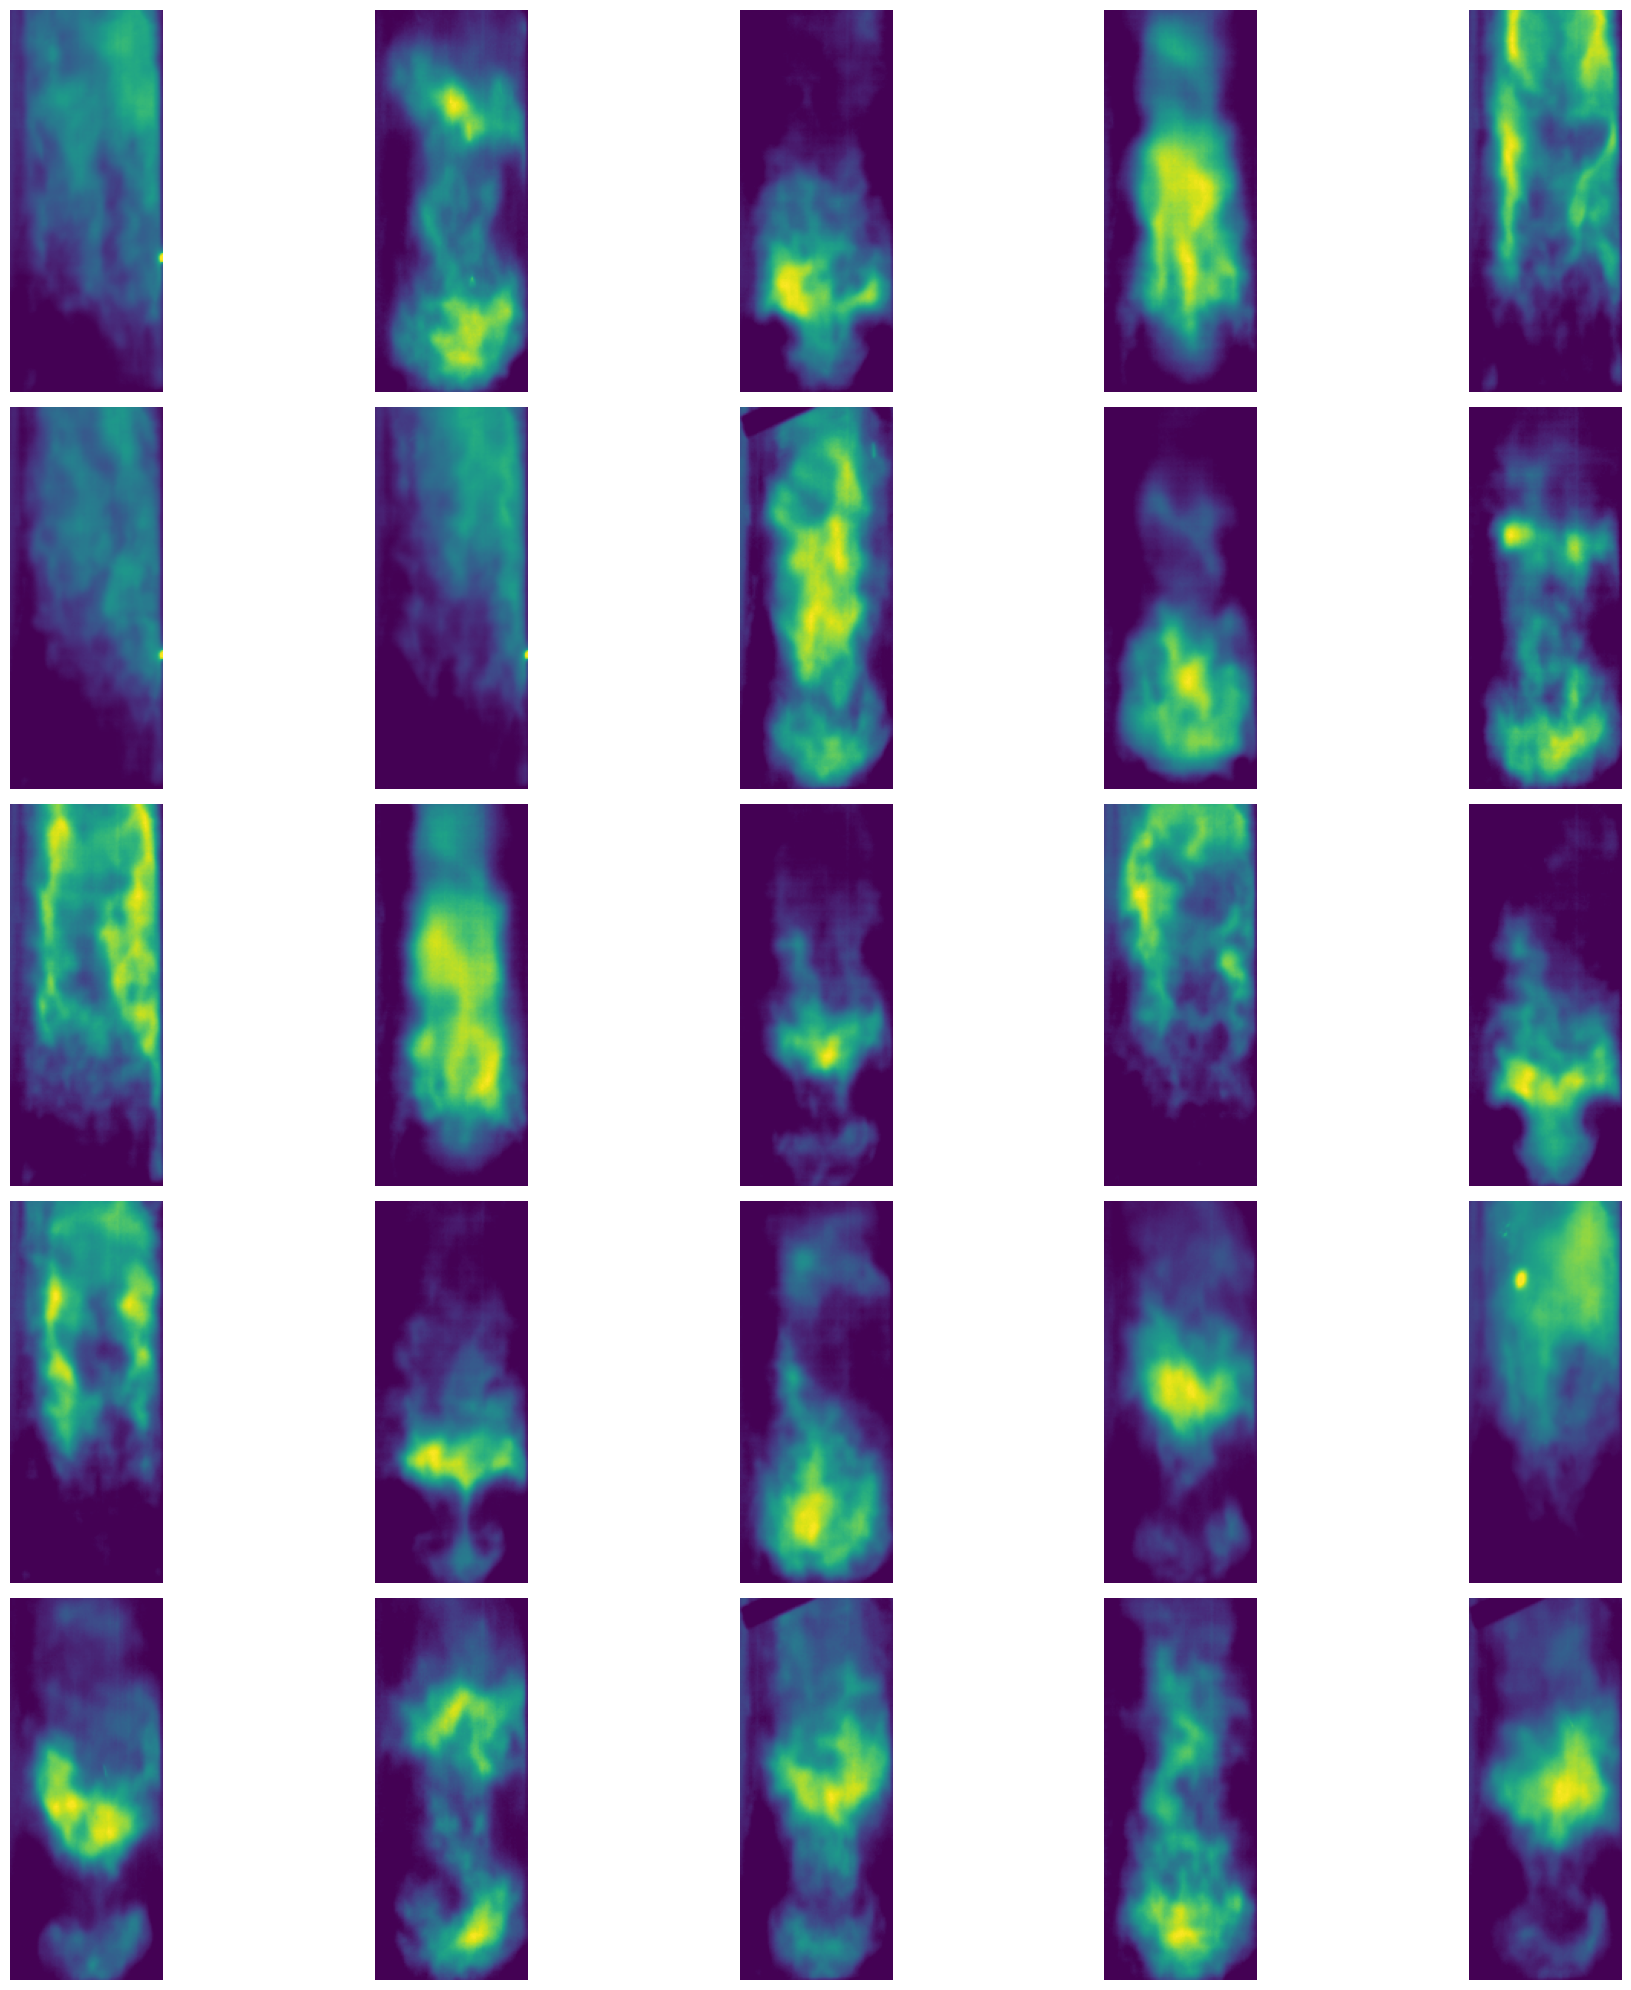

In [ ]:
plot_random(train_data)

In [ ]:

f = h5py.File(mat_file_path, 'r')
train_x = f.get("train_set_x")
train_y = f.get("train_set_y")

# Assuming the data is 2D (height, width) per sample
train_data = np.array(train_x).transpose((0, 2, 1))  # Transpose to get the correct orientation

# Add a channel dimension and convert to a PyTorch tensor
# Now shape should be [num_samples, 1, width, height]
train_data_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(1).to('cuda')
train_labels_tensor = torch.tensor(np.array(train_y), dtype=torch.long).to('cuda')

# Check the tensor shape to ensure it's correct
print(train_data_tensor.shape)

ValueError: axes don't match array

In [ ]:
class CombustionDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with h5py.File(file_path, 'r') as file:
            # Load the data correctly based on its structure
            self.data = file['train_set_x'][:].T  # Transpose if necessary
            self.labels = file['train_set_y'][:]

        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx, :]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        # No need to reshape if the sample is already a 1D vector of features
        return sample, label

In [ ]:
def transform(sample):
    # Convert sample to PyTorch tensor and normalize if necessary
    return torch.tensor(sample, dtype=torch.float32) / 255.0

In [ ]:
# Use the dataset with a DataLoader
batch_size = 32  # You can adjust the batch size as needed

# Initialize the dataset
combustion_dataset = CombustionDataset(mat_file_path, transform=transform)

# Create a DataLoader
train_loader = DataLoader(combustion_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
autoencoder = Autoencoder().to('cuda')
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(25000, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32)  # Bottleneck layer
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 25000)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
autoencoder = Autoencoder().to('cuda')
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
epochs = 10
for epoch in range(epochs):
    for data, labels in train_loader:
        data = data.to('cuda')  # Move data to GPU
        optimizer.zero_grad()
        output = autoencoder(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.003537339624017477
Epoch 2, Loss: 0.0032423106022179127
Epoch 3, Loss: 0.002778194611892104
Epoch 4, Loss: 0.002373848110437393
Epoch 5, Loss: 0.0027464337181299925
Epoch 6, Loss: 0.002473703818395734
Epoch 7, Loss: 0.002404462546110153
Epoch 8, Loss: 0.0029554625507444143
Epoch 9, Loss: 0.002443117555230856
Epoch 10, Loss: 0.0026562141720205545


In [ ]:
def get_latent_features(model, loader):
    model.eval()
    features = []
    with torch.no_grad():
        for data in loader:
            data = data.to('cuda')
            latent = model.encoder(data)
            features.append(latent.cpu())
    return torch.cat(features)

latent_train = get_latent_features(autoencoder, train_loader)

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self):
        super(SequentialModel, self).__init__()
        self.lstm = nn.LSTM(input_size=32, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 1)  # Assuming binary classification

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

In [ ]:
sequential_model = SequentialModel().to('cuda')
optimizer_seq = torch.optim.Adam(sequential_model.parameters(), lr=0.001)
criterion_seq = nn.BCEWithLogitsLoss()

# Assuming you have a way to create a DataLoader for the latent features
latent_loader = DataLoader(latent_train, batch_size=32, shuffle=True)

In [ ]:

epochs_seq = 10
for epoch in range(epochs_seq):
    for latent in latent_loader:
        # Assuming labels are available for the sequential model
        latent, labels = latent
        latent = latent.to('cuda')
        labels = labels.to('cuda')
        optimizer_seq.zero_grad()
        output = sequential_model(latent)
        loss = criterion_seq(output, labels)
        loss.backward()
        optimizer_seq.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
autoencoder = Autoencoder()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [ ]:
# Training loop for the Autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    autoencoder.train()
    optimizer.zero_grad()
    outputs = autoencoder(train_images)
    loss = criterion(outputs, train_images)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# After training the Autoencoder, get the latent features
latent_features_train = autoencoder.encoder(train_images).detach()
latent_features_valid = autoencoder.encoder(valid_images).detach()

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0

    for batch_images, _ in train_loader:
        optimizer.zero_grad()
        outputs = autoencoder(batch_images.todevice)
        loss = criterion(outputs, batch_images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss}")

RuntimeError: The size of tensor a (104) must match the size of tensor b (100) at non-singleton dimension 3

In [ ]:
# using GPU

for epoch in range(10):  # Number of epochs
    optimizer.zero_grad()
    output = model(train_data_tensor)
    loss = criterion(output, train_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [54000, 25000]

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self):
        super(SequentialModel, self).__init__()
        # Assuming the latent space size is 64*32*13 from the encoder output
        self.lstm = nn.LSTM(input_size=64*32*13, hidden_size=100, num_layers=2, batch_first=True)
        self.fc = nn.Linear(100, 2)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Use the last output for classification
        return x

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(64 * 62 * 25, 1000)
        self.fc2 = nn.Linear(1000, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 62 * 25)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Extract latent features for train and validation sets
def extract_latent_features(model, dataset):
    model.eval()
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    features = []
    with torch.no_grad():
        for batch_images, _ in loader:
            batch_features = model.encoder(batch_images)
            features.append(batch_features)

    return torch.cat(features, 0)

In [ ]:
# Instantiate and train the SequentialModel
sequential_model = SequentialModel()
optimizer_seq = torch.optim.Adam(sequential_model.parameters(), lr=1e-3)
criterion_seq = nn.CrossEntropyLoss()

NameError: name 'SequentialModel' is not defined

In [ ]:
latent_features_train = latent_features_train.view(latent_features_train.size(0), -1, 64*32*13)
latent_features_valid = latent_features_valid.view